<div style="padding:25px;color:white;margin:0;font-size:250%;text-align:center;display:fill;border-radius:10px;background-color:#298f50;overflow:hidden;font-weight:500;font-family:magra">Introduction</div>

* In this work i will do a cluster analysis for the problem of customer segmentation in the store 
* Cluster analysis refers to an unsupervised machine learning task (when there are no labels in the dataset)
* Cluster analysis is used where we need to break the general population into different groups, where the objects in each group are most similar to each other. In our example, we break the general population into separate groups in order to analyze these groups separately and, for example, make recommendations for purchases for them
* As part of this work, all stages of machine learning for cluster analysis will be considered
* The goal of this work is to obtain the necessary recommendations for business based on the results of cluster analysis

## If the work is useful for you, please upvote
## If you have any questions about the work, I will be happy to answer in the comments

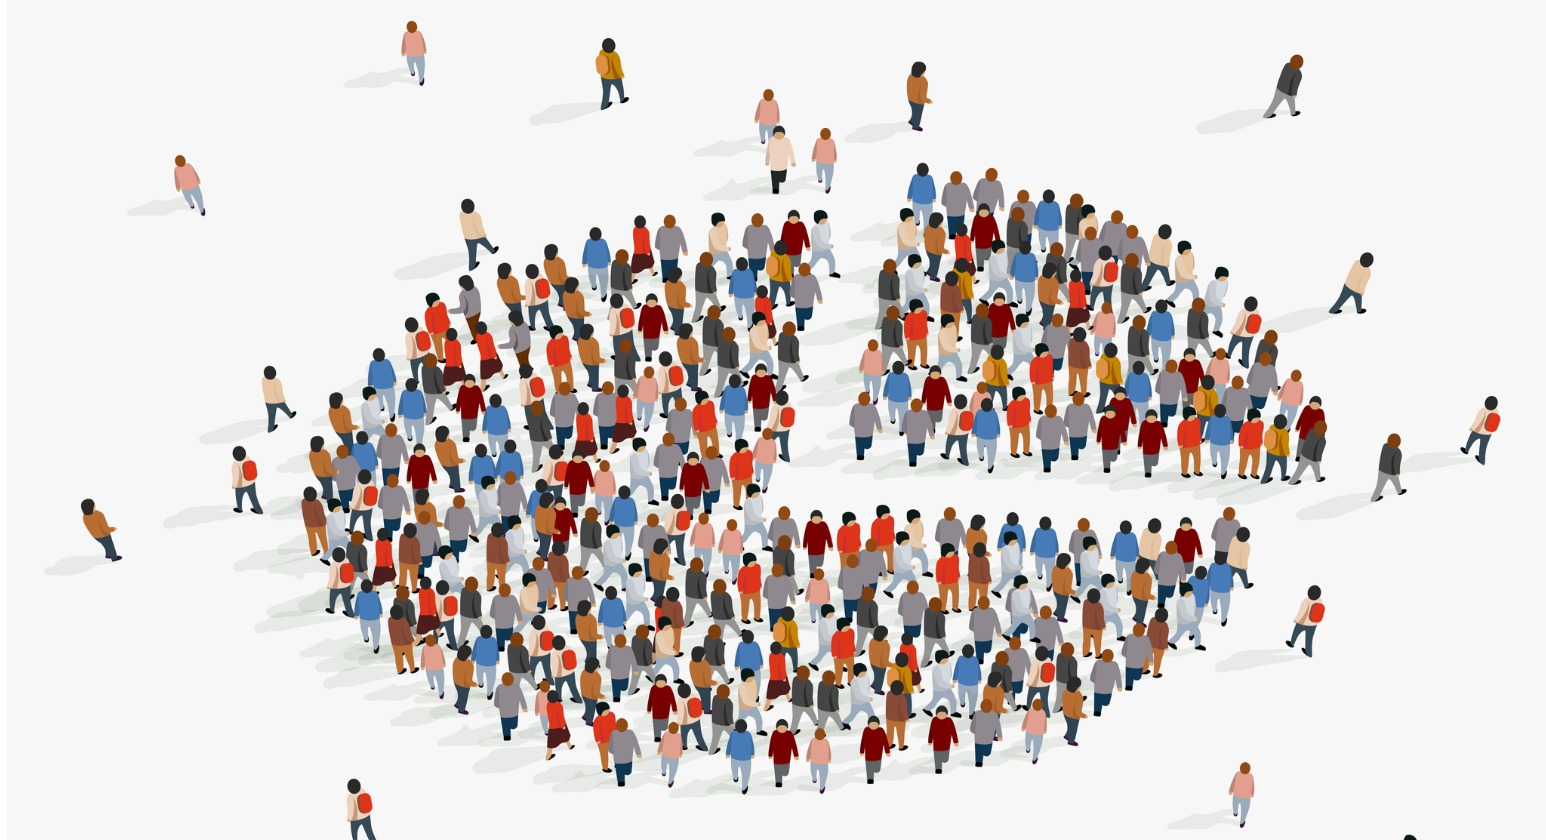

<div style="padding:25px;color:white;margin:0;font-size:250%;text-align:center;display:fill;border-radius:10px;background-color:#298f50;overflow:hidden;font-weight:500;font-family:magra">Table of content</div>

1) **Choice of Metrics**  
2) **Library import & Dataset**  
3.1) **Feature generation**  
3.2) **Data cleaning**              
3.3) **Data scaling (Normalization | Standartization)**  
4) **Dimensionality reduction**  
5) **Clustering**  
6) **Business Recommendations**  

<div style="padding:25px;color:white;margin:0;font-size:250%;text-align:center;display:fill;border-radius:10px;background-color:#298f50;overflow:hidden;font-weight:500;font-family:magra">1) Choice of Metrics  </div>

There are various metrics for clustering, for example:
* Silhouette coefficient  (https://scikit-learn.org/stable/modules/clustering.html#silhouette-coefficient)
* Calinski-Harabasz Index (https://scikit-learn.org/stable/modules/clustering.html#calinski-harabasz-index)
* Davies-Bouldin Index (https://scikit-learn.org/stable/modules/clustering.html#davies-bouldin-index)

In this work, in order to evaluate the quality of clustering, we will use the Silhouette coefficient metric as well as after dimensionality reduction, we will look at the data in three-dimensional space for a visual assessment of the quality of clustering. 

<div style="padding:25px;color:white;margin:0;font-size:250%;text-align:center;display:fill;border-radius:10px;background-color:#298f50;overflow:hidden;font-weight:500;font-family:magra">2) Library import & Dataset </div>

In [ ]:
import numpy as np
import pandas as pd 
import matplotlib.pyplot as plt
import seaborn as sns
import plotly.express as px
import sklearn
from sklearn.preprocessing import MinMaxScaler
from sklearn.metrics import silhouette_score
from sklearn.metrics import silhouette_samples
from sklearn.decomposition import PCA
from sklearn.cluster import KMeans, AgglomerativeClustering, SpectralClustering, DBSCAN
from datetime import datetime
import warnings
import sys
import os

In [ ]:
df = pd.read_csv('../input/customer-personality-analysis/marketing_campaign.csv', sep='\t')

In [ ]:
df.head(10)

# Features:
______________________________________________________________________________________________________________
### People

* ID: Customer's unique identifier  
* Year_Birth: Customer's birth year  
* Education: Customer's education level  
* Marital_Status: Customer's marital status  
* Income: Customer's yearly household income  
* Kidhome: Number of children in customer's household  
* Teenhome: Number of teenagers in customer's household  
* Dt_Customer: Date of customer's enrollment with the company  
* Recency: Number of days since customer's last purchase  
* Complain: 1 if the customer complained in the last 2 years, 0 otherwise  

### Products

* MntWines: Amount spent on wine in last 2 years
* MntFruits: Amount spent on fruits in last 2 years
* MntMeatProducts: Amount spent on meat in last 2 years
* MntFishProducts: Amount spent on fish in last 2 years
* MntSweetProducts: Amount spent on sweets in last 2 years
* MntGoldProds: Amount spent on gold in last 2 years

### Promotion

* NumDealsPurchases: Number of purchases made with a discount
* AcceptedCmp1: 1 if customer accepted the offer in the 1st campaign, 0 otherwise
* AcceptedCmp2: 1 if customer accepted the offer in the 2nd campaign, 0 otherwise
* AcceptedCmp3: 1 if customer accepted the offer in the 3rd campaign, 0 otherwise
* AcceptedCmp4: 1 if customer accepted the offer in the 4th campaign, 0 otherwise
* AcceptedCmp5: 1 if customer accepted the offer in the 5th campaign, 0 otherwise
* Response: 1 if customer accepted the offer in the last campaign, 0 otherwise

### Place

* NumWebPurchases: Number of purchases made through the company’s website
* NumCatalogPurchases: Number of purchases made using a catalogue
* NumStorePurchases: Number of purchases made directly in stores
* NumWebVisitsMonth: Number of visits to company’s website in the last month
______________________________________________________________________________________________________________


In [ ]:
df.info()

In [ ]:
print(f'Dataset size: {df.shape}')

In [ ]:
warnings.filterwarnings('ignore')  # ignore notifications

In [ ]:
def reduce_mem_usage(df: pd.DataFrame) -> pd.DataFrame:
    """Iterate through all the columns of a dataframe and modify the data type
        to reduce memory usage"""
    
    start_mem = df.memory_usage().sum() / 1024**2
    print('Memory usage of DataFrame is {:.2f} MB'.format(start_mem))
    
    for col in df.columns:
        col_type = df[col].dtype
        
        if col_type != object:
            c_min = df[col].min()
            c_max = df[col].max()
            if str(col_type)[:3] == 'int':
                if c_min > np.iinfo(np.int8).min and c_max < np.iinfo(np.int8).max:
                    df[col] = df[col].astype(np.int8)
                elif c_min > np.iinfo(np.int16).min and c_max < np.iinfo(np.int16).max:
                    df[col] = df[col].astype(np.int16)
                elif c_min > np.iinfo(np.int32).min and c_max < np.iinfo(np.int32).max:
                    df[col] = df[col].astype(np.int32)
                elif c_min > np.iinfo(np.int64).min and c_max < np.iinfo(np.int64).max:
                    df[col] = df[col].astype(np.int64)  
            else:
                if c_min > np.finfo(np.float32).min and c_max < np.finfo(np.float32).max:
                    df[col] = df[col].astype(np.float32)
                else:
                    df[col] = df[col].astype(np.float64)
        else:
            df[col] = df[col].astype('category')

    end_mem = df.memory_usage().sum() / 1024**2
    print('Memory usage after optimization is: {:.2f} MB'.format(end_mem))
    print('Decreased by {:.1f}%'.format(100 * (start_mem - end_mem) / start_mem))
    
    return df

In [ ]:
df = reduce_mem_usage(df)

<div style="padding:25px;color:white;margin:0;font-size:250%;text-align:center;display:fill;border-radius:10px;background-color:#298f50;overflow:hidden;font-weight:500;font-family:magra">3.1) Feature generation  </div>

In [ ]:
df['Age'] = datetime.now().year - df['Year_Birth']  # Client Age

In [ ]:
def get_different_year():
    registration_year = pd.to_datetime(df['Dt_Customer'], format='%d-%m-%Y').apply(lambda x: x.year)
    current_year = datetime.now().year
    return current_year - registration_year

df['Years_Since_Registration'] = get_different_year()  # Number of years since customer registration

In [ ]:
df["Education"] = df["Education"].replace({"Basic": 0, "Graduation": 1, "2n Cycle": 2, "Master": 2, "PhD": 3})
# Encoded in numbers in order

In [ ]:
df['Marital_Status'] = df["Marital_Status"].replace({"Married":"Partner", "Together":"Partner", "Absurd":"Alone",
    "Widow":"Alone", "YOLO":"Alone", "Divorced":"Alone", "Single":"Alone"})

step_2 = df['Marital_Status'].replace({'Alone': 1, 'Partner': 2})

df["Family_Size"] = step_2 + df['Kidhome'] + df['Teenhome']  # Total number of people in the family

df = pd.concat([df, pd.get_dummies(df['Marital_Status'])], axis=1)  # Separate features for Alone and Partner

In [ ]:
mnt_cols = ['MntWines', 'MntFruits', 'MntMeatProducts', 'MntFishProducts', 'MntSweetProducts', 'MntGoldProds']
df['Sum_Mnt'] = df[mnt_cols].sum(axis=1)  # Total amount spent on products

In [ ]:
accepted_cmp_cols = ['AcceptedCmp1', 'AcceptedCmp2', 'AcceptedCmp3', 'AcceptedCmp4', 'AcceptedCmp5',
                     'Response']
df['Num_Accepted_Cmp'] = df[accepted_cmp_cols].sum(axis=1)  
# Number of companies in which the client accepted the offer

In [ ]:
total_purchases = ['NumWebPurchases', 'NumCatalogPurchases', 'NumStorePurchases']
df['Num_Total_Purchases'] = df[total_purchases].sum(axis=1)  # Total number of purchases

# Let's look at EDA:
______________________________________________________________________________________________________________

## First, let's look at the correlation matrix:

In [ ]:
to_corr = ['Age', 'Income', 'Kidhome', 'Teenhome', 'Recency', 'Complain', 
          'MntWines', 'MntFruits', 'MntMeatProducts', 'MntFishProducts', 'MntSweetProducts', 
          'MntGoldProds', 'NumDealsPurchases', 'AcceptedCmp1', 'AcceptedCmp2', 'AcceptedCmp3', 
          'AcceptedCmp4', 'AcceptedCmp5', 'Response', 'NumWebPurchases', 'NumCatalogPurchases', 
          'NumStorePurchases', 'NumWebVisitsMonth', 'Years_Since_Registration', 'Family_Size',
           'Sum_Mnt', 'Num_Accepted_Cmp', 'Num_Total_Purchases', 'Alone', 'Partner']

cmap = sns.diverging_palette(220, 10, as_cmap=True)
matrix = np.triu(df[to_corr].corr())
plt.figure(figsize=(25, 14))
plt.title('Correlation matrix', fontsize=18)
sns.heatmap(df[to_corr].corr(), annot=True,
            fmt='.1f', vmin=-0.4, center=0, cmap=cmap, mask=matrix)

plt.show()

## Next, look at the distributions of quantitative variables:

In [ ]:
to_plot = ['Income', 'Recency', 'Age', 'Years_Since_Registration', 'Sum_Mnt',
           'Num_Total_Purchases', 'Marital_Status']
sns.pairplot(df[to_plot], hue='Marital_Status', palette='Set1')
plt.show()

<div style="padding:25px;color:white;margin:0;font-size:250%;text-align:center;display:fill;border-radius:10px;background-color:#298f50;overflow:hidden;font-weight:500;font-family:magra">3.2) Data cleaning </div>

## Remove gaps in the data:

In [ ]:
df.isna().sum()

In [ ]:
df.dropna(inplace=True)  # Removed objects with gaps in income

## Remove outliers in the data:

In [ ]:
def remove_outliers(data: pd.DataFrame, column: str) -> pd.Series:
    q3, q1 = np.nanpercentile(data[column], [75, 25])
    iqr = q3 - q1
    upper_bound = q3 + 1.5 * iqr
    lower_bound = q1 - 1.5 * iqr
    data = data[(data[column] > lower_bound) & (data[column] < upper_bound)]

    return data

df = remove_outliers(df, 'Age')
df = remove_outliers(df, 'Income')

## Remove unnecessary features:

In [ ]:
df.drop(['Year_Birth', 'ID', 'Z_CostContact', 'Z_Revenue', 'Dt_Customer', 'Marital_Status'], axis=1, inplace=True)

<div style="padding:25px;color:white;margin:0;font-size:250%;text-align:center;display:fill;border-radius:10px;background-color:#298f50;overflow:hidden;font-weight:500;font-family:magra">3.3) Data scaling (Normalization | Standartization)  </div>

Data scaling is necessary to bring all features to the same scale. If this is not done, then the attention of the algorithm will be attracted to features that include large values (this is bad)  
In this work, normalization will be used as data scaling (as a result of normalization, all features are in the range from 0 to 1)

In [ ]:
def scaling_func(df: pd.DataFrame) -> None:
    mms = MinMaxScaler()
    return pd.DataFrame(data=mms.fit_transform(df), columns=df.columns)


df_scaled = scaling_func(df)
df_scaled.index = df.index  # for convenient work with dataframes

<div style="padding:25px;color:white;margin:0;font-size:250%;text-align:center;display:fill;border-radius:10px;background-color:#298f50;overflow:hidden;font-weight:500;font-family:magra">4) Dimensionality reduction  </div>

The dimensionality reduction problem is used in the following situations:
* There are a lot of features in the dataset, and we want to reduce their number, leaving as much information as possible
* We have many features in the dataset, and we want to visualize the data (for example, in 3D space)
* Solving the problem of multicollinearity

There are many different options for dimensionality reduction, which are based on different methods, for example:
* Principal component analysis (PCA)
* Uniform Manifold Approximation and Projection (UMAP)
* t-distributed Stochastic Neighbor Embedding (t-SNE)
* Locally-Linear Embedding (LLE)
* Multidimensional Scaling (MDS)

The most commonly used dimensionality reduction algorithm is PCA, and we also use it in this work.  
Essentially, in PCA we make a transition from one variable space to another, with the new space containing fewer variables (n_component), where the new variables are uncorrelated and are the weighted sum of the old variables.  
As a result we get m variables: {PC1, PC2, PC3... PCm} , where PC1 will receive the most information(maximum sample variance), PC2 - less, and so on (A variable is considered informative if it has a high sample variance).  
8 components will be used in this work.

In [ ]:
def dim_reduction(data: pd.DataFrame) -> pd.DataFrame:
    n_components = 8
    pca = PCA(n_components=n_components, random_state=42)
    data = pd.DataFrame(pca.fit_transform(data), columns =([f'PC{i}' for i in range(1, n_components + 1)]))
    return data

df_transform = dim_reduction(df_scaled)  # df: scaling + dimensionality reduction
df_transform.index = df_scaled.index  # for convenient work with dataframes

<div style="padding:25px;color:white;margin:0;font-size:250%;text-align:center;display:fill;border-radius:10px;background-color:#298f50;overflow:hidden;font-weight:500;font-family:magra">5) Clustering</div>

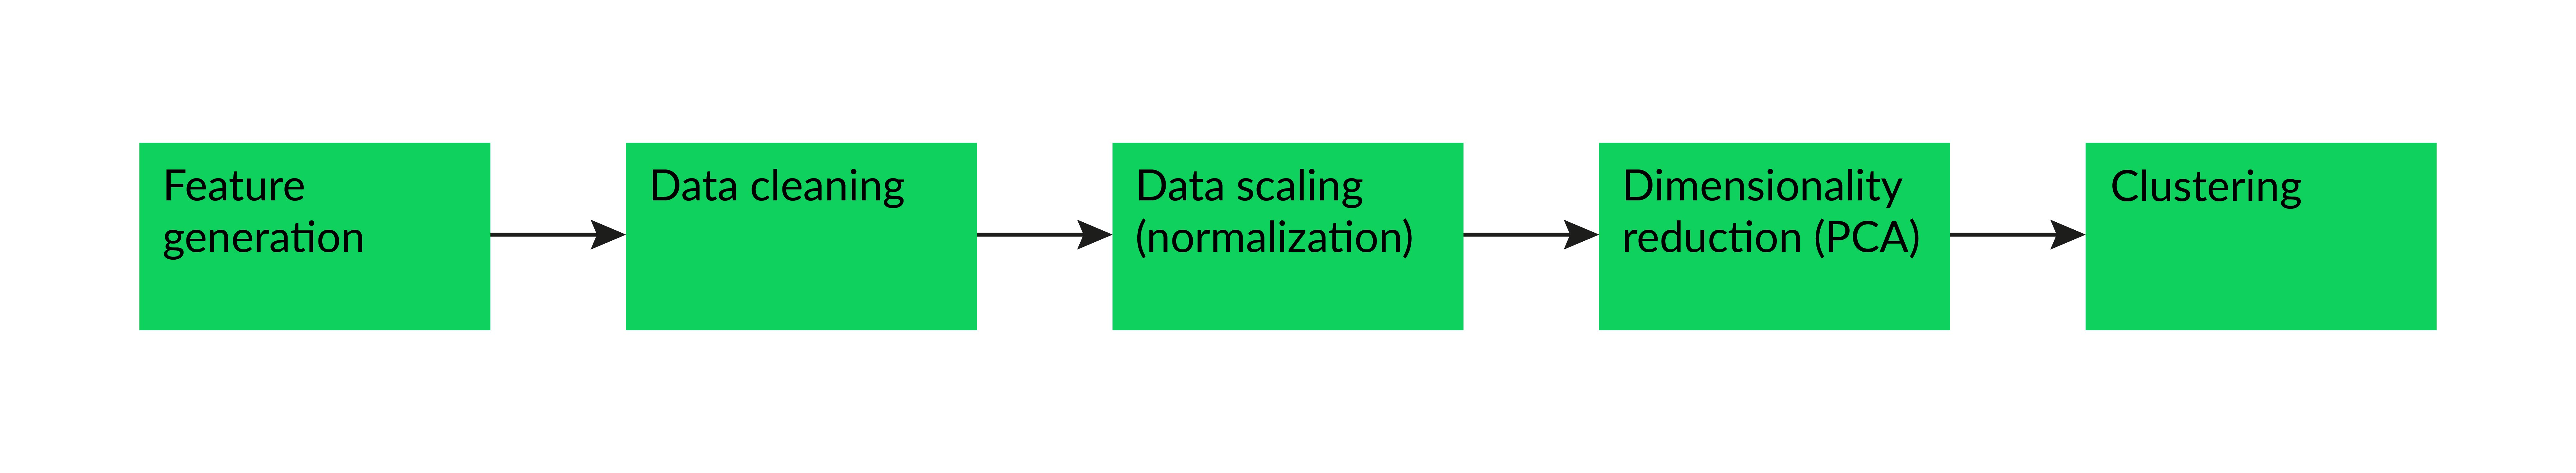

So, we have finished data preprocessing  
In total, we have three dataframes:
* df (with feature generation and data cleaning)  
* df_scaled (scaled version of df)
* df_transform (dimensionality reduction for df_scaled)

## Important:
We will apply clustering algorithms for df_transform, based on this we will get labels for all objects, then we will combine the label column for objects with df in order to get information about clusters (on graphs).

In this work, the following clustering algorithms will be used: (https://scikit-learn.org/stable/modules/clustering.html)
* K-means ++ 
* Aglomerative clustering
* Spectral clustering


It is noteworthy that in these algorithms it is necessary to pre-specify the number of clusters.     
We assume that the minimum number of clusters is two, the maximum number of clusters is eight. Based on this, for different cases of the number of clusters, we will build models.    
If the metric is maximum for models with a large number of clusters, then we will iteratively increase the maximum number of clusters and build new models.


In [ ]:
class Clustering:
    algorithms = ['KMeans', 'AgglomerativeClustering', 'SpectralClustering']
    min_n_clusters = 2
    max_n_clusters = 8
    kmeans_distortions = []  # Model distortions for different hyperparameters(n_clusters) 
    
    @staticmethod
    def sse_plot(): 
        """Graphs for the SSE values (KMeans)"""
        plt.figure(figsize=(25, 8))
        sns.set_style("darkgrid")
        plt.title('Distortion values for different number of clusters (for Kmeans)', fontsize=14, fontweight='bold')
        plt.xlabel('Clusters', fontsize=14, fontweight='bold')
        plt.ylabel('SSE',fontsize=14, fontweight='bold')
        plt.xticks(fontsize=14)
        plt.yticks(fontsize=14)
        plt.plot(list(range(Clustering.min_n_clusters, Clustering.max_n_clusters + 1)), Clustering.kmeans_distortions, marker='o')
        plt.show()
        
    
    @staticmethod
    def silhouette_result(metrics_score:list, algorithm: str):
        plt.figure(figsize=(25, 8))
        sns.set_style("darkgrid")
        plt.title(f'Silhouette score for different number of clusters (algorithm: {algorithm})', fontsize=14, fontweight='bold')
        plt.xlabel('Clusters', fontsize=14, fontweight='bold')
        plt.ylabel('Silhouette', fontsize=14, fontweight='bold')
        plt.xticks(fontsize=14)
        plt.yticks(fontsize=14)
        plt.plot(list(range(Clustering.min_n_clusters, Clustering.max_n_clusters + 1)), metrics_score, marker='o')
        plt.show()
        print('*' * 112)
    
          
    def make_models(self, data_old: pd.DataFrame, data_modified: pd.DataFrame):  
        """Method for creating models"""
        for algorithm in Clustering.algorithms:  
            metrics = []  # metrics: silhouette score
            for n_clusters in range(Clustering.min_n_clusters, Clustering.max_n_clusters + 1):  
                if algorithm == 'AgglomerativeClustering':
                    ac = AgglomerativeClustering(n_clusters=n_clusters,
                                                linkage='complete')
                    pred = ac.fit_predict(df_transform)
                    labels = pd.DataFrame(pred, columns =['Labels'], index=df.index)
                    metrics.append(silhouette_score(df_transform, labels))
                    Clustering.object_plot(labels, pred, algorithm)
                    
                if algorithm == 'SpectralClustering':
                    sc = SpectralClustering(n_clusters=n_clusters)
                    pred = sc.fit_predict(df_transform)
                    labels = pd.DataFrame(pred, columns =['Labels'], index=df.index)
                    metrics.append(silhouette_score(df_transform, labels))
                    Clustering.object_plot(labels, pred, algorithm)
                                              
                if algorithm == 'KMeans':  
                    kmeans = KMeans(n_clusters=n_clusters, 
                                    init="k-means++", 
                                    n_init=10,
                                    max_iter=280, 
                                    random_state=42)
                    pred = kmeans.fit_predict(df_transform) 
                    labels = pd.DataFrame(pred, columns=['Labels'], index=df.index)
                    metrics.append(silhouette_score(df_transform, labels))
                    Clustering.kmeans_distortions.append(kmeans.inertia_)  
                    Clustering.object_plot(labels, pred, algorithm)
                        
            if algorithm == 'KMeans':
                Clustering.sse_plot()
                print('*' * 112)
                    
            Clustering.silhouette_result(metrics, algorithm)
                                     
                        
    @staticmethod
    def object_plot(labs: pd.DataFrame, predict:np.array, algorithm:str):  # здесь cтроим графики кол-ва объектов в кластере и силуэтного скора для модели 
        """Graphs of the number of objects in a cluster and the silhouette coefficient"""
        cluster_group = labs.groupby('Labels').size()
        plt.figure(figsize=(25, 5))
        plt.subplot(1, 2, 1)
        sns.set_style("darkgrid")
        plt.title(f'Cluster size (algorithm: {algorithm})', fontsize=14, fontweight='bold')
        sns.barplot(x=cluster_group.values, y=list(map(str, cluster_group.index)))
        plt.xlabel('Number of objects', fontsize=14, fontweight='bold')
        plt.ylabel('Сlusters', fontsize=14, fontweight='bold')
        plt.xticks(fontsize=14)
        plt.yticks(fontsize=14)
                
        plt.subplot(1, 2, 2)         
        cluster_labels = np.unique(predict)
        silhouette_vals = silhouette_samples(df_transform, predict, metric='euclidean')
        y_ax_lower, y_ax_upper = 0, 0
        yticks = []
        for i, с in enumerate(cluster_labels):
            c_silhouette_vals = silhouette_vals[predict == с]
            c_silhouette_vals.sort()
            y_ax_upper += len(c_silhouette_vals)
            plt.barh(range(y_ax_lower, y_ax_upper),
                   c_silhouette_vals,
                   height = 1,
                   edgecolor='none')

            yticks.append((y_ax_lower + y_ax_upper) / 2)
            y_ax_lower += len(c_silhouette_vals) 
        silhouette_avg = np.mean(silhouette_vals)
        plt.axvline(silhouette_avg, color="red", linestyle="--")
        sns.set_style("darkgrid")
        plt.title(f'Silhouette plot for different clusters (algorithm: {algorithm})', fontsize=14, fontweight='bold')   
        val = float(''.join([i for i in str(silhouette_avg)][0:5]))
        plt.xlabel(f'Silhouette = {val}', fontsize=14, fontweight='bold')
        plt.ylabel('Clusters', fontsize=14, fontweight='bold')
        plt.yticks(yticks, cluster_labels, fontsize=14)
        plt.show()
        print('*' * 112)
                                                 

clustering = Clustering()
clustering.make_models(df, df_transform)

# What can we say from these graphs:  
* Good metric results for Agglomerative and Spectral Clustering algorithms  
* Best Model: AgglomerativeClustering(n_clusters=3).

# Now let's build graphs of the main characteristics for features int | float for the best models (since we got object labels)

In [ ]:
best_model = AgglomerativeClustering(n_clusters=3)
labels = pd.DataFrame(best_model.fit_predict(df_transform), columns=['Clusters'], index=df.index)
df = pd.concat([df, labels], axis=1)

In [ ]:
object_cols = ['Education', 'Kidhome', 'Teenhome', 'Family_Size', 'Alone', 'Partner']
num_cols = ['Income', 'Recency', 'MntWines',
            'MntFruits', 'MntMeatProducts', 'MntFishProducts',
            'MntSweetProducts', 'MntGoldProds', 'NumDealsPurchases',
            'NumWebPurchases', 'NumCatalogPurchases','NumStorePurchases',
            'NumWebVisitsMonth', 'Age', 'Years_Since_Registration',
            'Sum_Mnt', 'Num_Accepted_Cmp', 'Num_Total_Purchases']

In [ ]:
def graph_builder():
    """Graphs of the main characteristics for features int | float for the best models.
    The best model was chosen based on the results of the graphs"""
    def boxplot():
        n_cols = len(num_cols)
        rows = n_cols // 3 
        _, axes = plt.subplots(ncols=3, nrows=rows, figsize=(25, 5 * rows))
        plt.subplots_adjust(wspace=0.3, hspace=0.4)
        for num, col in enumerate(num_cols):
            b = sns.boxplot(
                 data=df,
                 y=col,
                 x="Clusters",
                 palette="Paired",
                 ax=axes.reshape(-1)[num])
            b.set_xlabel('Clusters', fontsize=14)
            b.set_ylabel(f'{df[col].name}', fontsize=14)
            sns.set_style('darkgrid')
    
    def histplot():    
        n_cols = len(num_cols)
        rows = n_cols // 3
        _, axes = plt.subplots(ncols=3, nrows=rows, figsize=(25, 5 * rows))
        plt.subplots_adjust(wspace=0.3, hspace=0.4)
        for num, col in enumerate(num_cols):
            h = sns.histplot(
                 data=df,
                 x=col,
                 hue="Clusters",
                 multiple="stack",
                 kde=True,
                 palette="Paired",
                 ax=axes.reshape(-1)[num])
                
            h.set_xlabel(f'{df[col].name}', fontsize=14)
            h.set_ylabel('Count', fontsize=14)
            sns.set_style('darkgrid')
            
    def barplot():
        n_cols = len(object_cols)
        rows = n_cols // 3 + n_cols % 3
        size_cluster = df.groupby("Clusters").count().iloc[:, 0]
        _, axes = plt.subplots(ncols=3, nrows=rows, figsize=(25, 5 * rows))
        plt.subplots_adjust(wspace=0.3, hspace=0.4)    
        for num, col in enumerate(object_cols):
            data = (df.groupby(["Clusters"])[col].value_counts().unstack(fill_value=0).T)
            data = pd.DataFrame(data.unstack())
            data.columns = ["Number of objects"]
            data = data.reset_index()
            b= sns.barplot(
                 data=data,
                 x=data[col],
                 hue=data.Clusters,
                 y=data['Number of objects'],
                 ax=axes.reshape(-1)[num])
            b.set_xlabel(f'{data[col].name}', fontsize=14)
            b.set_ylabel('Number of objects', fontsize=14)
            sns.set_style('darkgrid')
    
    boxplot()
    histplot()
    barplot()
    
graph_builder()

<div style="padding:25px;color:white;margin:0;font-size:250%;text-align:center;display:fill;border-radius:10px;background-color:#298f50;overflow:hidden;font-weight:500;font-family:magra">6) Business Recommendations</div>

# As a result of cluster analysis, we received three groups of buyers (clusters):
# 0 cluster:
* Middle income people (average income equals 50000)
* Average age is 52 years
* Have an education (Graduation, 2n Cycle, Master, PhD)
* People without family, people with families with and without children
* Quite often buy wines, but they also often buy meat
* Most often make purchases on the web
* The average number of purchases is 13

# 1 cluster:
* High income people (average income equals 70000)
* Average age is 55 years
* Have an education (Graduation, 2n Cycle, Master, PhD)
* Have a family with children (Teenhome)
* Quite often buy wines, but they also often buy meat
* Most often make purchases in the stores themselves
* Most often make purchases (compared to other clusters)

# 2 cluster:
* Average income equals 38000 
* Average age is 49 years
* Have an education (Graduation, 2n Cycle, Master, PhD)
* People with families with and without children
* A low number of purchases and, accordingly, spend little money on purchases 

<div style="padding:25px;color:white;margin:0;font-size:250%;text-align:center;display:fill;border-radius:10px;background-color:#298f50;overflow:hidden;font-weight:500;font-family:magra">END</div>